In [1]:
import scipy as sp
import numpy as np
import pandas as pd
import timeit
import re
import json
import pickle
import fastparquet
import os
os.chdir('/mnt/t48/bighomes-active/sfeng/patentdiffusion/')
seed = 3
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
import datetime
import logging
import itertools

In [10]:
pdf = fastparquet.ParquetFile("RawData/Cleaned/patent_loc_unique_us_0628.parq")\
.to_pandas(["patent", "primclass", "naics_name", "inv_msa", "gyear"])
dup_pats = pd.read_pickle("RawData/Cleaned/duplicate_pattext_0712.pkl").tolist()
# Get relevant US Patents
pdf = pdf.loc[~pdf["patent"].isin(dup_pats)]
# Rename columns
pdf = pdf.rename(columns={"primclass": "Primclass"})
pdf = pdf.loc[pdf["Primclass"].notnull()]
pdf["Primclass"] = pdf["Primclass"].astype(int)
# Get pharma patents
p2 = pdf.loc[pdf["naics_name"] == "Pharmaceutical and Medicines"]

In [11]:
dm = "docvecs"
pm = fastparquet.ParquetFile("DataStore/2018-07-P2/ML/{0}_pats_0712.parq".format(dm))\
    .to_pandas().values
# Only use patents in patdict
pat_dict = fastparquet.ParquetFile("RawData/Cleaned/patabs7615_us_no_dup.parq").to_pandas(["patent"])["patent"].tolist()
pat_dict = dict(zip(pat_dict, range(len(pat_dict))))
p2 = p2.loc[p2["patent"].isin(pat_dict.keys())]

pm = np.array([pm[pat_dict[p]] for p in p2["patent"].tolist()])

In [12]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
%time pca_v = pca.fit_transform(pm)

p2["PCA Component 1"] = [i[0] for i in pca_v]
p2["PCA Component 2"] = [i[1] for i in pca_v]

CPU times: user 1.1 s, sys: 51.7 ms, total: 1.16 s
Wall time: 294 ms


### Plot PCA

In [22]:
p2 = p2.loc[p2["Primclass"].notnull()]

In [41]:
p2["Primclass"] = p2["Primclass"].astype(int)

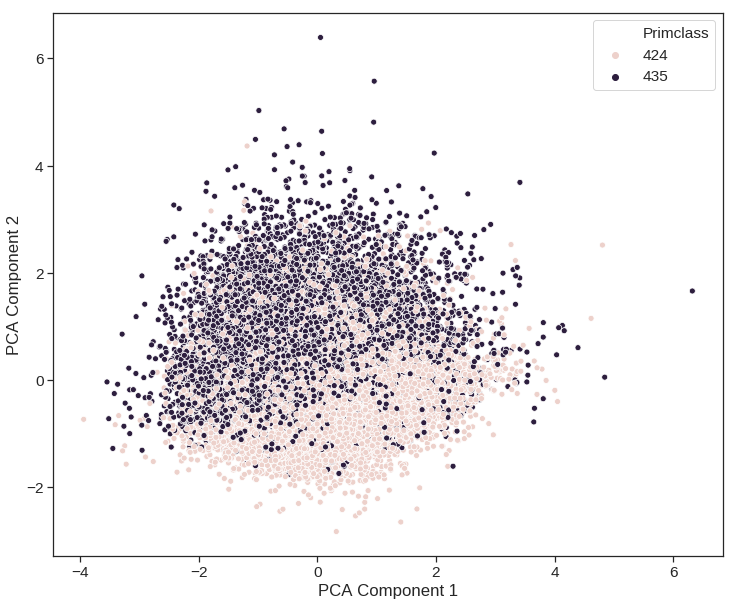

In [52]:
%matplotlib inline
sns.set(font_scale=1.4)
sns.set_style("ticks")
plt.rcParams["font.family"] = "Liberation Sans"
plt.rcParams.update({'font.size': 14})
plt.style.use('seaborn-muted')

fig, ax = plt.subplots(figsize=(12,10))
p1 = sns.scatterplot(x="PCA Component 1",y="PCA Component 2", hue="Primclass", legend="full", data=p2, ax=ax)
# ax.legend_.remove()
plt.savefig("DataStore/2018-10/ResultsGraphs/pca_pharma.png")

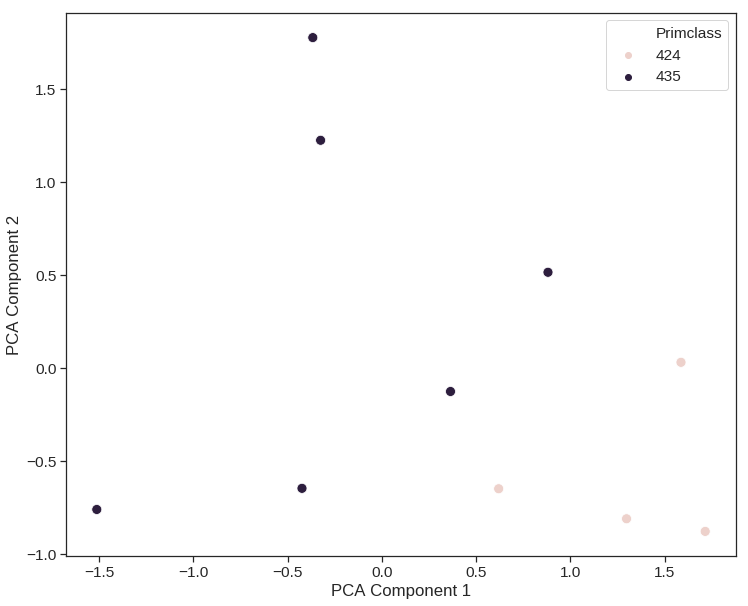

In [54]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12,10))
p3 = p2.sample(10, random_state = 20)
p1 = sns.scatterplot(x="PCA Component 1",y="PCA Component 2", hue="Primclass", data=p3,
                     s=100, legend="full", ax=ax)
plt.savefig("DataStore/2018-10/ResultsGraphs/pca_pharma_example.png")

In [38]:
p2["Primclass"] = p2["Primclass"].astype("category")
